Install requirements

In [ ]:
%pip install numpy pandas matplotlib
%pip install pyarrow fastparquet

In [27]:
%pip list |grep fastparquet

fastparquet               2024.5.0
Note: you may need to restart the kernel to use updated packages.


Import libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pyarrow
import fastparquet

## Instruction 1

In [6]:
def generate_image(image_shape: tuple[int, int, int]):
    """ Generates an RGB Image represented by 3 matrices of dimensions (m, n)
    """
    if image_shape[2] == 3:
        image = np.random.randint(0, 256, size=image_shape)
        return image
    else:
        raise ValueError("Image shape is not correct, a tuple (m, n, 3) is required")

def generate_random_batches(n_batches: int, n_images: int, image_shape: tuple[int, int, int]):
    """ Generates a list of random image batches
    """
    return [[generate_image(image_shape) for _ in range(n_images)] for _ in range(n_batches)]


def plot_batches(batches):
    """ Plot images in row"""
    # Flatten images to plot them on the same line
    flattened_images = [image for batch in batches for image in batch]

    num_images = len(flattened_images)

    # Create subplots 
    if num_images > 1:
        fig, axes = plt.subplots(1, num_images)
        for ax, image in zip(axes, flattened_images):
            ax.imshow(image)
            ax.axis()
    else:
        plt.imshow(flattened_images[0])

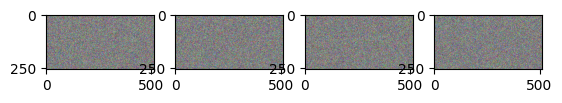

In [13]:
# Use 2 batches and 2 images for easier visualisation and test
generated_batches = generate_random_batches(n_batches=2, n_images=2, image_shape=(256, 512, 3))
    
plot_batches(generated_batches)

## Instruction 2

In [9]:
def verify_overlapping_positions(x1, y1, x2, y2, square_size) -> bool:
    """ Check if two squares overlap.
    """
    if abs(x1 - x2) < square_size or abs(y1 - y2) < square_size:
        return True
    return False


def apply_square(image, x_pos, y_pos, square_size, color):
    """
    Apply Square of a given color to an image.
    x_pos and y_pos represent the top left of the square to add.
    """
    image[y_pos:y_pos+square_size, x_pos:x_pos+square_size, :] = color

    return image


def alter_image(image, square_size):
    """ Adds one black and one white square to an image, added squares do not overlap
    """

    # Find two random non-overlapping positions for each black and white squares, top-left position of the square
    # Generate two random coordinates (x1, y1) (x2, y2) within the image, that verfiy both these conditions:
    # |x1 - X2| > square_size and |y1 - y2| > square_size
    m = image.shape[0] # height
    n = image.shape[1] # width
    # Square size must fit in the image
    if square_size >= min(m,n)/2 or square_size <= 0:
        raise ValueError(f"Square size is bigger than the image size/2 or negative: {square_size}")
    
    overlapping = True
    while overlapping:
        # Random positions constrained only by the limits of the image
        x1 = np.random.randint(0, n - square_size)
        y1 = np.random.randint(0, m - square_size)

        x2 = np.random.randint(0, n - square_size) 
        y2 = np.random.randint(0, m - square_size)
       
        overlapping = verify_overlapping_positions(x1, y1, x2, y2, square_size)
    
    # print(x1, y1)
    # print(x2, y2)

    # Apply squares to the image on the positions found
    altered_image = apply_square(image, x1, y1, square_size, color=0) # Black square
    altered_image = apply_square(image, x2, y2, square_size, color=255) # White square

    return altered_image

def add_randomly_placed_squares(image_batches, square_size):
    """ Inserts two squares white and black to each image in the batches"""
    return [[alter_image(image, square_size) for image in batch] for batch in image_batches]


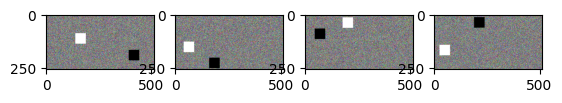

In [14]:
altered_batches = add_randomly_placed_squares(generated_batches, square_size=50)
plot_batches(altered_batches)

## Instruction 3

In [17]:
def random_crop(image, new_size):
    """ Returns a random subset of the image of size new_size"""
    # Pick random top-left postion with respect to the new size and image size
    m = image.shape[0] # number of rows
    n = image.shape[1] # number of columns

    if new_size > min(m,n) or new_size <= 0:
        raise ValueError(f"New size is bigger than the image or negative: {new_size}")
    x_pos =  np.random.randint(0, n - new_size+1)
    y_pos =  np.random.randint(0, m - new_size+1)

    croped_image = image[y_pos:y_pos+new_size, x_pos:x_pos+new_size, :]
    return croped_image

def random_crop_batches(batches, new_size):
    """ Randomly crops all images in batches of images to a given size"""
    return [[random_crop(image, new_size) for image in batch] for batch in batches]

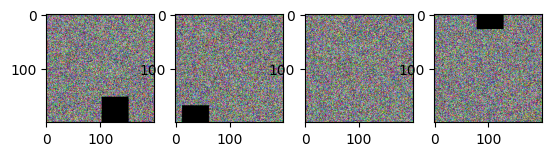

In [18]:
croped_batches = random_crop_batches(batches=altered_batches, new_size=200)
plot_batches(croped_batches)

## Instruction 4 - 5

In [22]:
def count_pixels(image, pixel:tuple[int, int, int]):
    """ Counts the occurences of an RGB value in an image
    """
    pixel_count = np.sum(np.all(image==pixel, axis=-1)) # Condition must match all the three RGB layers -> axis = 2 or -1
    return pixel_count


def get_batch_stats(images, batch_id:str):
    """ Returns pd.dataframe stats about black and white pixels in a list of images"""

    white_counts = []
    black_counts = []

    for image in images:
        white_counts.append(count_pixels(image, (255, 255, 255)))
        black_counts.append(count_pixels(image, (0, 0, 0)))
    
    # Average
    white_avg = np.average(white_counts)
    black_avg = np.average(black_counts)

    # Min 
    white_min = np.min(white_counts)
    black_min = np.min(black_counts)

    # Max
    white_max = np.max(white_counts)
    black_max = np.max(black_counts)

    # Std
    white_std = np.std(white_counts)
    black_std = np.std(black_counts)

    data = {
        'batch_id': batch_id,
        'white_avg': white_avg,
        'white_min': white_min,
        'white_max': white_max,
        'white_std': white_std,

        'black_avg': black_avg,
        'black_min': black_min,
        'black_max': black_max,
        'black_std': black_std,
    }

    return pd.Series(data)

def get_stats(batches):
    rows = [get_batch_stats(batch, f"batch_{idx}") for batch, idx in zip(batches, range(len(batches)))]
    df = pd.DataFrame(rows)
    return df


In [23]:
df = get_stats(croped_batches)
df.head()

,batch_id,white_avg,white_min,white_max,white_std,black_avg,black_min,black_max,black_std
0,batch_0,0.0,0,0,0.0,1950.0,1550,2350,400.0
1,batch_1,0.0,0,0,0.0,700.0,0,1400,700.0


In [35]:
# Save to a parquet file
df.to_parquet(path='/home/mh06/projects/test-repo/output_dataframes/output_2_2.parquet')

## OQ 10
In the context of AWS or another cloud provider you are familiar with, how would you
deploy this code? It should read images from an object storage and be triggered only when
5 batches of 20 images are available. It will then publish the information in a database and
send a message to the end user. Propose the underlying infrastructure as well as a DB
schema. Please explain your reasoning

1. I would create a github actions CI/CD to push the docker container to a registry (DockerHub, AWS ECR, ...)
2. Create an s3 bucket to save the generated images 
3. Create a Lambda function that pulls the latest image and runs the transformation on the last added images on the s3 bucket, saves the dataframe to a relational db (RDS)
4. DB schema would be almost the same as the output dataframe with metadata columns like creation_time (it would be included in the PK)
5. Use SQS for sending notifications


# Open Question 10
**How would you deploy this code?** 

The code 
- generates random images given (n_batches and n_images), 
- does some processing  
- calculates statistics on white and black pixels in each batch of images
- saves the stats as parquet file into an s3 bucket
- is packaged using docker


### It should read images from an object storage
- Images need to be first uploaded to s3 bucket, add a new function:

In [ ]:
def save_images_s3(batches, bucket, path):
    # Initialize the S3 client
    s3_client = boto3.client('s3')
    
    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    
    # Iterate over batches
    for batch_index, batch in enumerate(batches):
        # Iterate over images
        for index, image in enumerate(batch):
            # Create the full path for the image
            image_path = f"{path}_{timestamp}/batch_{batch_index}/image_{index}.png"
            
            # Convert np.ndarray to image object
            image_obj = convert_np_to_obj(image)

            # Upload the image to S3
            s3_client.upload_fileobj(image_obj, bucket, image_path)
            print(f"Uploaded {image_path} to {bucket}")

save_images_s3(batches_images, 'raw', 'processed')

### Be triggered only when 5 batches of 20 images are available. 

create a lambda event that checks in an s3 bucket for the latest added folder of images,
- counts the number of sub folders 
- counts the total number of images in the latest added folder, 
- if n_sub_folders == 5 and n_total_images == 20, trigger the following operations: 
- load the images in batches: a sub folder = batch of images 
- call get_stats(batches) ->
- save df to s3 as parquet file
- save information to db

Serverless is better suitable for this case of batch processing as we don't have a high availability and short downtime requirements.

### It will then **publish the information in a database**
Information to save:
- current_timestamp
- batchs_path_s3
- stats_path_s3
- n_batches
- n_images

A key-value database suits well this kind if information, we can use DynamoDB as it is managed by AWS which makes it easy to scale.

### Send a message to the end user

SNS service can be used to send a notification whenever there is a new record in the database 